# EIP1559 with adjustable target blocksize


Let $2B^*$ denote the maximum blocksize available. We aim investigating the effect of a variable target block-size in an EIP-1559 mechanism, for which  the basefee $b_t$ at an epoch $t$ is updated according to 

$$b_{t+1}=b_t\left(1+\frac{1}{8}\frac{B_t-B^T_t}{B^T_t}\right), \quad \quad \text{ Eq. (1)}$$

where $B_t\in[0,2B^*]$ is the gas consumption at epoch $t$ and where the target block size $B^T_t\in(0,B^*]$ is given by

\begin{aligned}
 B^T_{t+1}&:=H(T_t,T_{t-1},B_t,B_{t-1},B^T_t)\\
 &:=H(\Delta T_t,\Delta B_t,B^T_t), \quad \text{where we defined $\Delta T_t:=T_t-T_{t-1},$ and $\Delta B_t:= B_{t}=B_{t-1}$}.
 \end{aligned}

Here $T_t$ is some epoch-dependent target utility function and $H:\mathbb{R}^3\to(0,B^*)$ is the function that we aim at investigating.

### Some implications of having a variable blocksize. 


One needs to be careful when dealing with variable target blocksizes, as it can lead to exploding values for the base fee, as shown shortly. We begin with a definition. 

**Definition 1:** *Let $f,h:\mathbb{R}\to\mathbb{R}$ be two real-valued functions, having an asymptote at $x=a$, $a\in\mathbb{R}$. We say that $f$ is* of  class "big-O at $a$" in $h$, *denoted by $f\in O(h;a)$ if $$\lim_{x\to a} \frac{f(x)}{h(x)}<+\infty.$$*

Given this, we can claim the following:

**Claim 1.** *Evertything else being equal, either the gas consumption $B_t$ is $O(B^T_t;0)$ or the base fee becomes infinitely large as $B^T_t\to0$*. 

*Proof.* Consider a base fee mechanism as in Eq. (1), with an adjustable blocksize $B^T_t\in(0,B^*]$. Taking the limit as $B^T_t\to0$ yields

$$ \lim_{B^T_t\to 0^+} b_{t+1}= \lim_{B^T_t\to 0^+} b_t\left(1+\frac{1}{8}\frac{B_t-B^T_t}{B^T_t}\right)=\lim_{B^T_t\to 0^+} b_t\left(1+\frac{1}{8}\left(\frac{B_t}{B^T_t}-1\right)\right),$$

which is finite if and only if $\lim_{B^T_t\to 0} B_t/B_{t}^T<+\infty$.

Given this, one needs to be extra careful when designing $H$. One could, e.g., define $H$ in such a way that $H:\mathbb{R}^3\to[B^T_\text{min},B^T_\text{max}]$, for some carefully chosen values of $B^T_\text{min}$ and $B^T_\text{max}$.

 Alternatively, one could design it in such a way that $$\lim_{B^T_t\to 0} \frac{\partial H(\Delta t,\Delta B_t,B^T_t)}{\partial B^T_t}=0, \ \forall \Delta t,\Delta B_t \in\mathbb{R}.$$
















### Defining the mapping $H$.

 In particular, we enforce $H$ to satisfy the following properties:

If $\Delta T_t> 0$ and $\Delta B_t> 0$, then $H(\Delta T_t,\Delta B_t,B^T_t)>B^T_t$.

If $\Delta T_t> 0$ and $\Delta B_t< 0$, then $H(\Delta T_t,\Delta B_t,B^T_t)<B^T_t$.

If $\Delta T_t< 0$ and $\Delta B_t> 0$, then $H(\Delta T_t,\Delta B_t,B^T_t)<B^T_t$.

If $\Delta T_t< 0$ and $\Delta B_t< 0$, then $H(\Delta T_t,\Delta B_t,B^T_t)>B^T_t$.

The idea being that if gas usage increased, and this was a good outcome for the target function, then the target block size should be increased to incentivize even more gas usage, and so on for the other scenarios.

Here we consider several functional forms of $H$, namely:

\begin{aligned}
H^1(\Delta T_t,\Delta B_t,B^T_{t};\alpha)&:=\left[1+2\alpha_1\left(1-\frac{B^T_t}{B^*}\right)^{\alpha_2} \frac{\Delta T_t\Delta B_t}{\Delta B_t^2+\Delta T_t^2}\right]B^T_t, \quad \alpha_1\in\mathbb{R}_+, \ \alpha_2\geq 1,\\
H^2(\Delta T_t,\Delta B_t,B^T_{t};\alpha)&:=\left[1+\alpha_1\arctan(\alpha_2\Delta T_t\Delta B_t)\right]B^T_t \quad \alpha_1,\alpha_2\in\mathbb{R},\\
H^3(\Delta T_t,\Delta B_t,B^T_{t})&:=w_tH^0+(1-w_t)H^1, \quad w_t=B^T_t/B^*, \text{ and } H^0:=B^T_t,\\
H^4(\Delta T_t,\Delta B_t,B^T_{t})&:=\left(\frac{B_{t}^T}{B^*}\right)^2\left[(1-H^j_t)B_t^T+H_tB^*\right]+\frac{(B^*-B_t^T)^2}{(B^*-B_t^T)^2+(B_t^T)^2}H^i_tB_t^T, \text{ with  }i,j\in\{1,2,3\}. 
\end{aligned}

Notice that the term $2\frac{\Delta T_t\Delta B_t}{\Delta B_t^2+\Delta T_t^2}$ here is bounded between [-1,1], indeed, this follows from the fact that for any $a,b\in \mathbb{R},$ one has that $0\leq(a^2+b^2)=a^2+b^2-2ab,$ which in turn implies that $2ab\leq a^2+b^2.$

We begin by importing the relevant libraries and defining these functions.


In [2]:
import numpy as np
import matplotlib.pyplot as plt


class H:
    def __init__(self,a,Bs,ind):
        '''
        Generates a function H class
            Parameters
        ----------
        a : np.array
            parameters
        Bs : float
            b star
        ind : int
            index of wheather we are using H1,H2,H3,H4
        '''
        self.index=ind
        self.a=a
        self.Bs=Bs
    def eval(self,dt:float,db:float,BT:float):
        ''' evaluates the update function H
        
        These parameters will be used in H1-H4

        Parameters
        ----------
        dt : float
            Delta t
        db : float
            delta B
        BT : float 
                BT, the current tatget
        '''
        
        ind=self.index
        if ind==1:
            return self.H1(dt,db,BT)
        elif ind==2:
            return self.H1(dt,db,BT)
        elif ind==3:
            return self.H3(dt,db,BT)
        elif ind==4:
            return self.H4(dt,db,BT)

            

    
    def H1(self,dt:float,db:float,BT:float):
        
        a1=self.a[0]
        a2=self.a[1]
        Bs=self.Bs
        frac=dt*db/(dt**2+db**2)
        wa2=(1-BT/Bs)**a2
        mult=1+2*a1*wa2*frac
        return mult*BT
    
    def H2(self,dt:float,db:float,BT:float):
        a1=self.a[0]
        a2=self.a[1]
        return (1+a1*np.arctan(a2*dt*db))
    
    def H3(self,dt:float,db:float,BT:float):
        w=BT/self.Bs
        return w*BT+(1-w)*self.H1(dt,db,BT)
    
    def H4(self,dt:float,db:float,BT:float):
        Bs=self.Bs
        w1=(BT/self.Bs)**2.
        w2=(Bs-BT)**2./((Bs-BT)**2. + BT**2 )
        term1=BT-self.H2(dt,db,BT)+self.H2(dt,db,Bs)
        term2=self.H2(dt,db,BT)
        
        return w1*term1 +w2*term2
    

Having defined these functions, we now focus on formulating a simulation environment. Let us write, for simplicity, $H^j=H$ to denote either of the update functions $H^j=1,2,3,4$ defined above. 
At a mechanistic level, the following events occur at each epoch $t$:

1. Given $b_{t-1}$, $B_{t-1}$, $B^T_{t-1}$, users consume a random amount of gas $B_t$. This amount is random, and will induce $T_t$: the miner utility.
2. Given these quantities, one can compute $\Delta T_t$ and $\Delta B_t$
3. From this, one could compute $B^T_{t+1}=H(\Delta T_t,\Delta B_t, B^T_t)$
4. Update values and iterate

The most important pieces here are (1) to determine the distribution $\pi_t$ of $B_t$ and (2) the precise definition of the target fucntion. 

For (1), we assume, for simplicity, that  $\frac{B_t-B_{t-1}}{B^T_t}\overset{\text{iid}}{\sim} \mathcal{N}(0,0.5)$, with $B_{-1}=1$ and $B_0$ known; which implies that $\pi_t= \text{Normal}(B_{t-1},{B^T_t}^2/2)$. In practice, a sample $x_t\sim\pi_t$ will need to be projected to $(0,2B^*)$. This is an acceptable approximation of the gas consumption in the Filecoin network with constant blocksize. 

For (2), based on the [derivation](https://hackmd.io/37c7UTGbQq6MuprD23k0jw?both) of variable blocksize, we take $$T_t:= W\left(\frac{S}{S-b_tB_t}-1\right)-b_t\cdot Q,$$

where $W$ is the total wealth of miners, $S$ is the circulating supply and $Q$ is the amount of token burnt by the miners, for miner related messages.

We now define some of these relevant functions. 





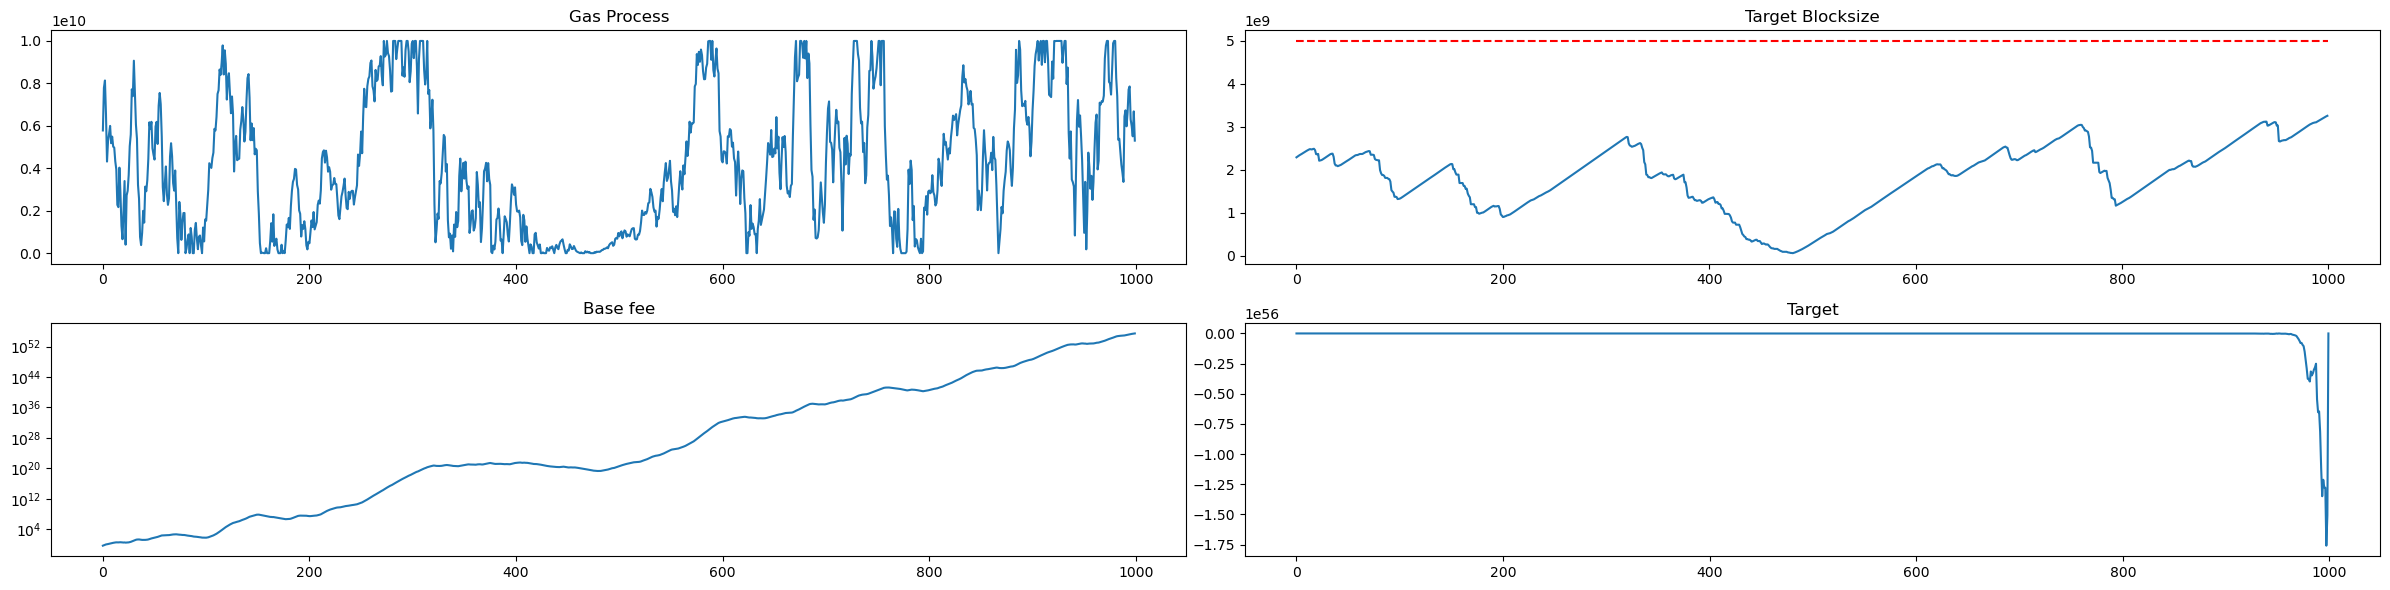

In [4]:
def T(b_t:float,B_t:float):
    ''' evaluates the target utility function'''
    r=0.01/100 # participation on the network
    nanoToFIL=1e-9
    S=300e6 #300 M FIL
    W=120e6 #iirc form a previous analysis
    FILBurnt=b_t*B_t*nanoToFIL 
    Q=FILBurnt*0.95 # usually, about 95% of messages are for storage (control plane)
    
    T=r*W*(S/(S-FILBurnt)-1)-FILBurnt
    return T


def sample_Bt(Bt_:float,BT:float):
    '''samples Bt given b_{t-1}'''
    B_MAX=10_000_000_000 #gas units
    Bs=B_MAX//2   
    Bt=Bt_+  BT*np.random.standard_normal()/2
 
    if Bt<0: 
        Bt=0
    if Bt>2*Bs:
        Bt=2*Bs        
    return Bt

def bt_fun(bt,Gt,BT):
    ''' vomputes base fee'''
    
    bt=bt*(1+1/8*(Gt-BT)/BT)
    return bt
    

def runSimulation(bt0,Bt0,BT0,Nsteps,ind,a):
    B_MAX=10_000_000_000 #gas units
    Bs=B_MAX//2
    Hfun=H(a,Bs,ind) # defines H function
    H_hist=np.zeros(Nsteps)
    bt_hist=np.zeros(Nsteps)
    Bt_hist=np.zeros(Nsteps)
    T_hist=np.zeros(Nsteps)
    H_hist[0]=BT0
    bt_hist[0]=bt0
    Bt_hist[0]=Bt0
    T_hist[0]=T(bt0,Bt0)
    
    
    for i in range(Nsteps-1):
        
        
        Bt_hist[i+1]=sample_Bt(Bt_hist[i],H_hist[i]) #new Bt
        bt_hist[i+1]=bt_fun(bt_hist[i],Bt_hist[i+1],H_hist[i]) # updated base fee
        
        db=bt_hist[i+1]-bt_hist[i]
        dB=Bt_hist[i+1]-Bt_hist[i]
        T_hist[i]=T(bt_hist[i+1],Bt_hist[i+1])
        dt=T_hist[i+1]-T_hist[i]
     

        H_hist[i+1]=Hfun.eval(dt,db,H_hist[i])
    
    res={'BT':H_hist,
         'T':T_hist,
         'baseFee':bt_hist,
         'gas':Bt_hist}
    return res


a=np.array([1/8,0])
ind=1
bt0=0.5 #nanoFIL 
Bt0=10e9*np.random.random()
BT0=5e9*np.random.random()
nsteps=1000
res=runSimulation(bt0,Bt0,BT0,nsteps,ind,a)
        
fig,ax=plt.subplots(2,2,figsize=(24,6))        
ax[0,0].plot(res['gas'])
ax[0,0].set_title('Gas Process')
ax[0,1].plot(res['BT'])
ax[0,1].hlines(y=5e9,xmin=0,xmax=nsteps,linestyles='dashed',color='red')
ax[0,1].set_title('Target Blocksize')

ax[1,0].semilogy(res['baseFee'])
ax[1,0].set_title('Base fee')

ax[1,1].plot(res['T'])
ax[1,1].set_title('Target')

plt.tight_layout()
  
    
    
    
    

In [31]:
Hfun=H(a,5e9,ind) # defines H function
Hfun.eval(dt,db,H_hist[i])


NameError: name 'dt' is not defined

In [9]:
x=np.linspace(-10,10,1000)
Bs=1 # for simplicity, B^*=1 
y=np.linspace(-Bs,Bs,1000)
dt,db=np.meshgrid(x,y)
H = lambda dt,db,Bt,a : 1+2*(1-Bt/Bs)**a * dt*db/(dt**2+db**2)
a=2
N_sims=1000
N_steps=1000
paths=[]
initialB=[]
for n in range(N_sims):
    B_current=np.random.random()
    b0=np.random.random()
    initialB.append(b0)
    target=np.zeros(N_steps)
    target[0]=b0
    
    
    for j in range(N_steps-1):
        dt=sample_dt()
        db=sample_db(B_current,Bs)
        B_current=B_current+db
        target[j+1]= H(dt,db,target[j],a)*target[j]
    paths.append(target)
        

Text(0.5, 1.0, 'final value of $B^T_{t_f}$')

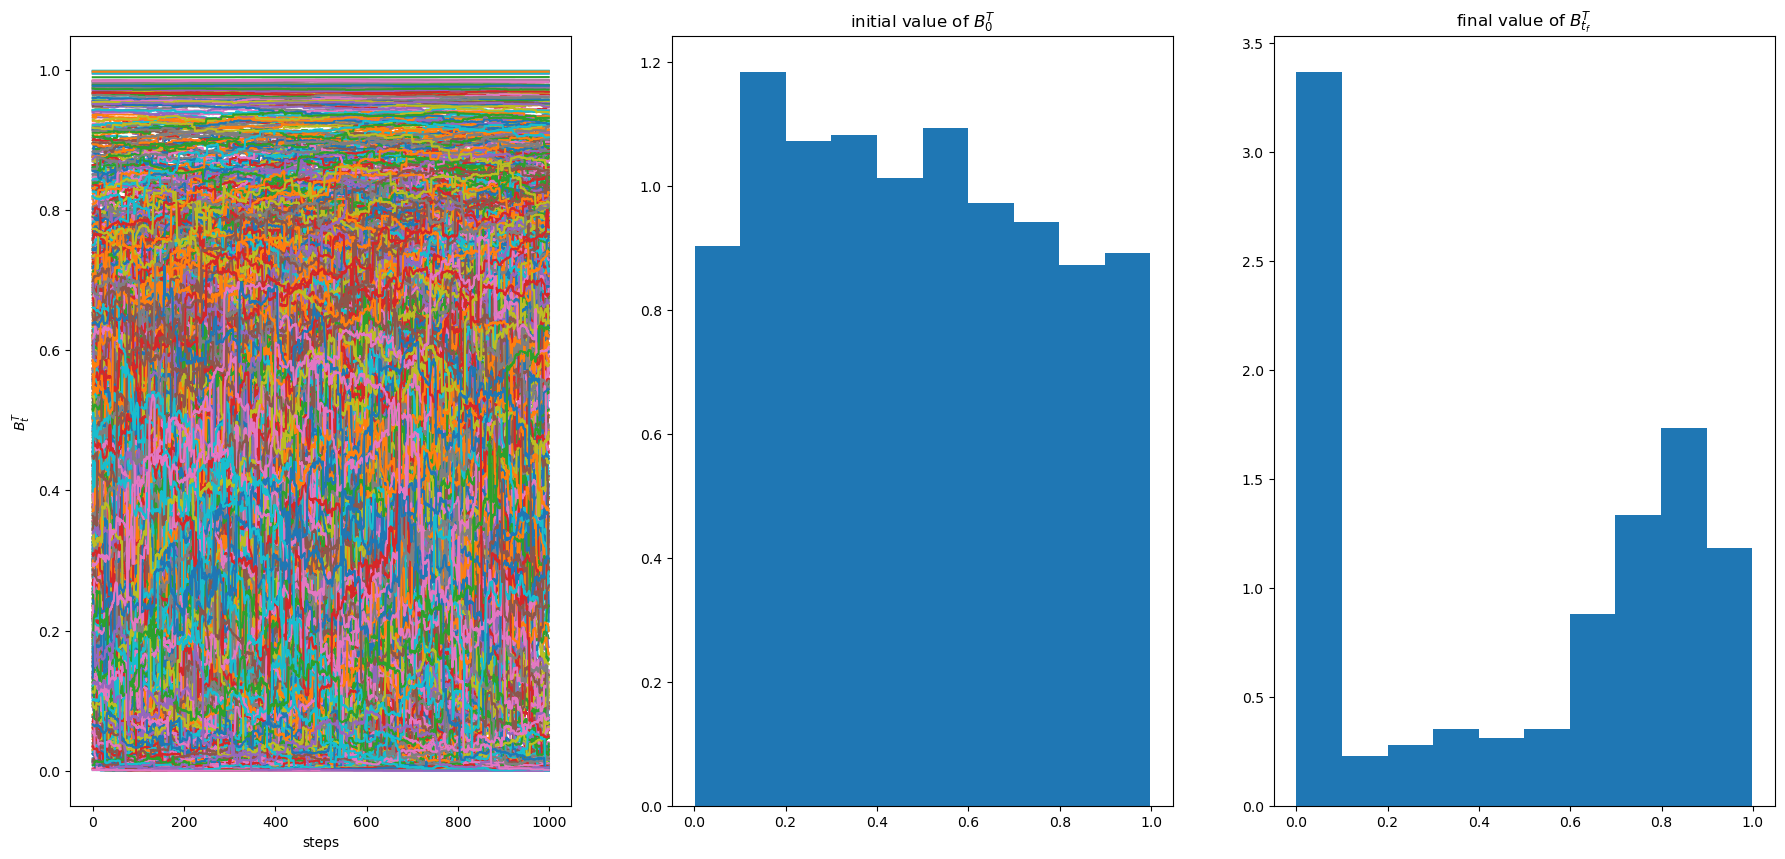

In [8]:
fig,ax=plt.subplots(1,3,figsize=(22,10))
finalB=[]

for p in paths:
    ax[0].plot(p)
    finalB.append(p[-1])
ax[0].set_xlabel('steps')
ax[0].set_ylabel(r'$B^T_t$')

ax[1].hist(initialB,density=True)
ax[1].set_title('initial value of $B^T_0$')


ax[2].hist(finalB,density=True)
ax[2].set_title('final value of $B^T_{t_f}$')


## Second option

We now consider an update function of the form: 

\begin{aligned}
H_t=w_tH_t^1+(1-w_t)H_t^2,
\end{aligned} 
with $w:=\frac{B^T_t}{B^*}$, $H_t^1=1$, and 
\begin{aligned}
H^2_t=1+2k \frac{\Delta T_t\Delta B_t}{\Delta B_t^2+\Delta T_t^2}, \quad k\in\mathbb{R}_+
\end{aligned}

Thus, if $B^T_t\approx B^*$, there's no change in target size. 

In [ ]:
x=np.linspace(-10,10,1000)
Bs=1 # for simplicity, B^*=1 
y=np.linspace(-Bs,Bs,1000)
dt,db=np.meshgrid(x,y)
H = lambda dt,db,Bt,a : 1+2*(1-Bt/Bs)**a * dt*db/(dt**2+db**2)
a=2
N_sims=1000
N_steps=1000
paths=[]
initialB=[]
for n in range(N_sims):
    B_current=np.random.random()
    b0=np.random.random()
    initialB.append(b0)
    target=np.zeros(N_steps)
    target[0]=b0
    
    
    for j in range(N_steps-1):
        dt=sample_dt()
        db=sample_db(B_current,Bs)
        B_current=B_current+db
        target[j+1]= H(dt,db,target[j],a)*target[j]
    paths.append(target)